In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================================
# 1. LOAD INPUT DATA
# ============================================

ladder = pd.read_excel("Scenario1_Ladder.xlsx")
opt    = pd.read_excel("Optimised_Hedge_Formatted.xlsx")

ladder.rename(columns={"Reporting Month": "ReportingMonth"}, inplace=True)
opt.rename(columns={"Reporting Month": "ReportingMonth"}, inplace=True)

ladder["ReportingMonth"] = pd.to_datetime(ladder["ReportingMonth"])
opt["ReportingMonth"]    = pd.to_datetime(opt["ReportingMonth"])

# Drop any blank rows
ladder = ladder.dropna(subset=["ReportingMonth"])
opt    = opt.dropna(subset=["ReportingMonth"])



In [2]:
# ============================================
# 2. FIX MERGED-HEADER FORMAT FROM EXCEL
# ============================================

def rebuild_columns(df):
    cols = df.columns.tolist()
    new_cols = ["ReportingMonth"]
    i = 1

    while i < len(cols):
        hdr = cols[i]
        if isinstance(hdr, str) and ("24" in hdr or "25" in hdr):
            season = hdr.split("–")[0].strip()  # e.g. "S24"
            new_cols += [
                f"{season}_Exposure",
                f"{season}_HedgeVolume",
                f"{season}_WAP",
                f"{season}_MtM"
            ]
            i += 4
        else:
            i += 1

    df.columns = new_cols
    return df

ladder = rebuild_columns(ladder)
opt    = rebuild_columns(opt)

In [3]:
# ============================================
# 3. MERGE SCENARIO 1 & SCENARIO 2
# ============================================

comp = pd.merge(
    ladder,
    opt,
    on="ReportingMonth",
    suffixes=("_Ladder", "_Optimised")
)

comp = comp.dropna(subset=["ReportingMonth"]).reset_index(drop=True)

In [4]:
# ============================================
# 4. LOAD FORWARDS + OUTTURN FROM A.xlsx
# ============================================

df_fwd = pd.read_excel(
    "A.xlsx",
    sheet_name="NBP Forwards",
    parse_dates=["Date"]
)

df_outturn = pd.read_excel(
    "A.xlsx",
    sheet_name="NBP Outturn",
    parse_dates=["Date"]
)

df_fwd["Date"] = pd.to_datetime(df_fwd["Date"])
df_outturn["Date"] = pd.to_datetime(df_outturn["Date"])



In [5]:
# ============================================
# 5. SEASON METADATA
# ============================================

SEASONS = {
    "S24": {"delivery_start": pd.Timestamp("2024-04-01"),
            "delivery_end":   pd.Timestamp("2024-09-30")},
    "W24": {"delivery_start": pd.Timestamp("2024-10-01"),
            "delivery_end":   pd.Timestamp("2025-03-31")},
    "S25": {"delivery_start": pd.Timestamp("2025-04-01"),
            "delivery_end":   pd.Timestamp("2025-09-30")},
    "W25": {"delivery_start": pd.Timestamp("2025-10-01"),
            "delivery_end":   pd.Timestamp("2026-03-31")}
}

In [6]:
# ============================================
# 6. FORCE WAP COLUMNS TO NUMERIC
# ============================================

for season in SEASONS.keys():
    for suffix in ["_Ladder", "_Optimised"]:
        col = f"{season}_WAP{suffix}"
        if col in comp.columns:
            comp[col] = pd.to_numeric(comp[col], errors="coerce")

In [7]:
# ============================================
# 7. COMPUTE REALISED & MTM
# ============================================

def compute_realised_and_mtm(df, season):

    delivery_start = SEASONS[season]["delivery_start"]
    delivery_end   = SEASONS[season]["delivery_end"]

    # Outturn averages
    outturn = df_outturn.copy()
    outturn["Month"] = outturn["Date"].dt.to_period("M")
    outturn_avg = outturn.groupby("Month")["DA"].mean()

    # Forward averages
    fwd = df_fwd.copy()
    fwd["Month"] = fwd["Date"].dt.to_period("M")
    fwd_avg = fwd.groupby("Month")[season].mean()

    real_L, real_O, mtm_L, mtm_O = [], [], [], []

    for _, row in df.iterrows():

        # reporting month check
        if pd.isna(row["ReportingMonth"]):
            real_L.append(0); real_O.append(0)
            mtm_L.append(0);  mtm_O.append(0)
            continue

        month = row["ReportingMonth"].to_period("M")

        volL = row[f"{season}_HedgeVolume_Ladder"]
        volO = row[f"{season}_HedgeVolume_Optimised"]
        wapL = row[f"{season}_WAP_Ladder"]
        wapO = row[f"{season}_WAP_Optimised"]

        # invalid WAP → 0 PnL
        if pd.isna(wapL) or pd.isna(wapO):
            real_L.append(0); real_O.append(0)
            mtm_L.append(0);  mtm_O.append(0)
            continue

        rL = rO = mL = mO = 0

        # DELIVERY REALISED
        if delivery_start <= row["ReportingMonth"] <= delivery_end:
            if month in outturn_avg.index:
                p = outturn_avg.loc[month]
                rL = volL * (wapL - p) / 100
                rO = volO * (wapO - p) / 100

        # PRE-DELIVERY MTM
        else:
            if month in fwd_avg.index:
                p = fwd_avg.loc[month]
                mL = volL * (wapL - p) / 100
                mO = volO * (wapO - p) / 100

        real_L.append(rL); real_O.append(rO)
        mtm_L.append(mL);  mtm_O.append(mO)

    df[f"{season}_Realised_Ladder"]    = real_L
    df[f"{season}_Realised_Optimised"] = real_O
    df[f"{season}_MtM_Ladder"]         = mtm_L
    df[f"{season}_MtM_Optimised"]      = mtm_O

    return df


In [8]:
# ============================================
# 8. BUILD SEASON DATASETS
# ============================================

season_dfs = {}

for season in SEASONS.keys():
    cols = ["ReportingMonth"] + [c for c in comp.columns if c.startswith(season)]
    df_s = comp[cols].copy()
    df_s = compute_realised_and_mtm(df_s, season)
    season_dfs[season] = df_s

print("\nSeason datasets built successfully.\n")



Season datasets built successfully.




====== S24 ======


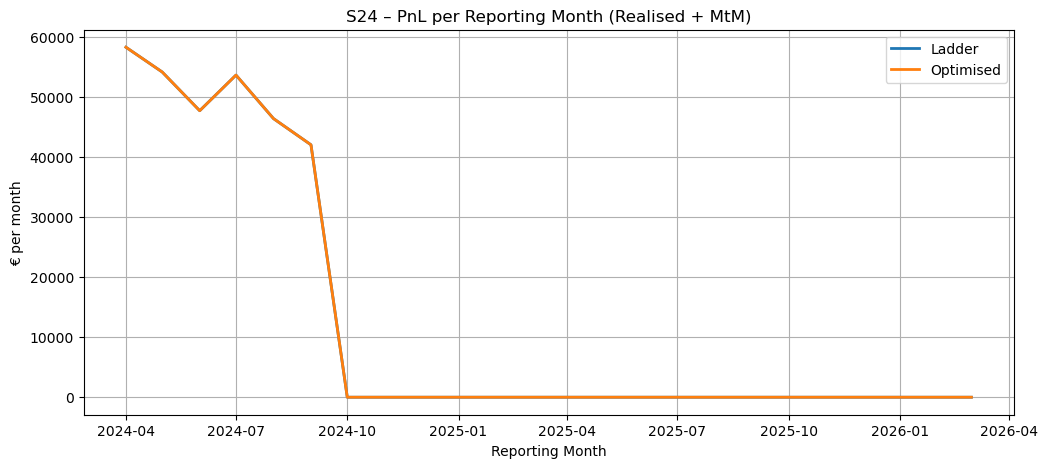

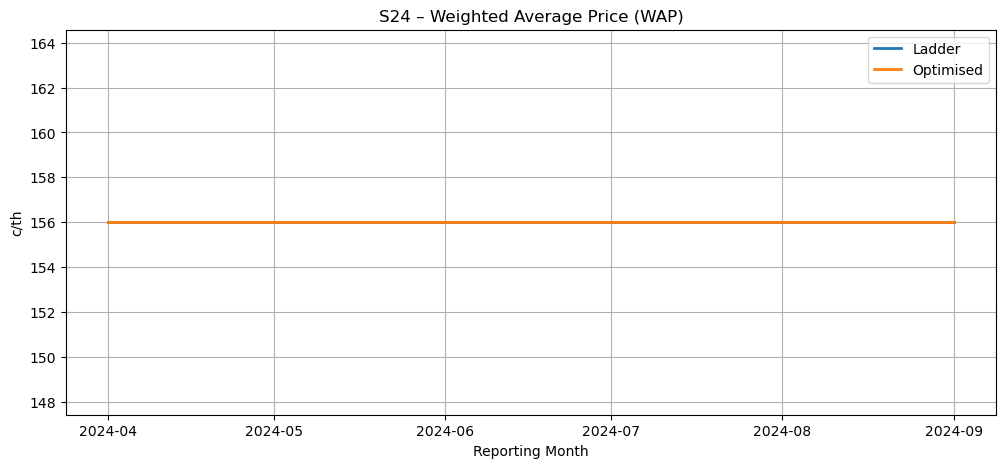

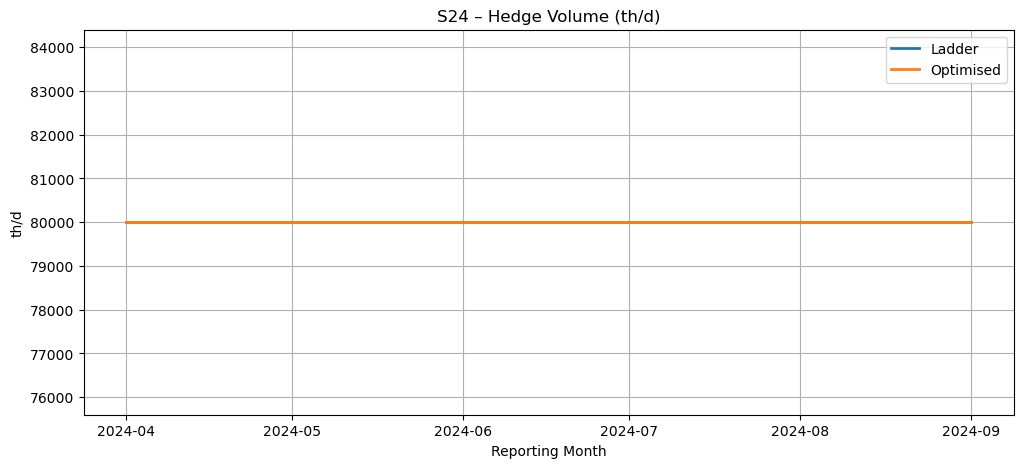


====== W24 ======


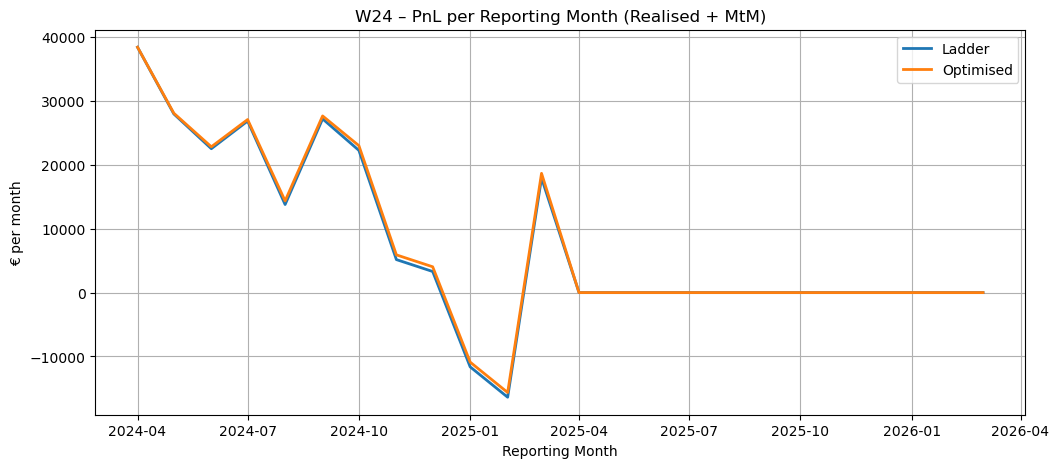

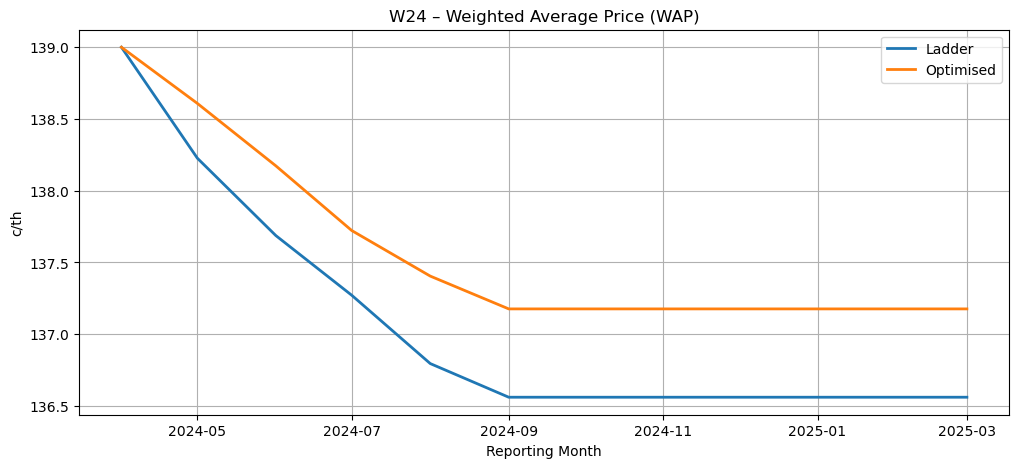

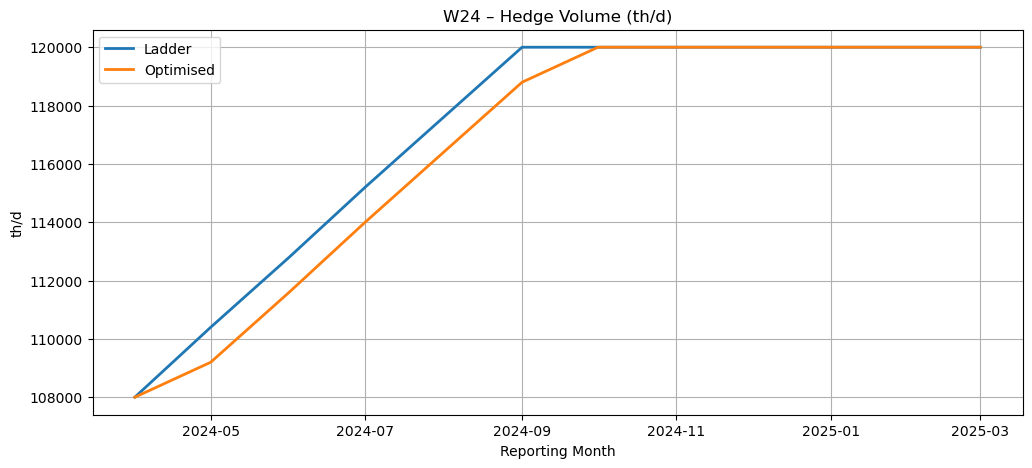


====== S25 ======


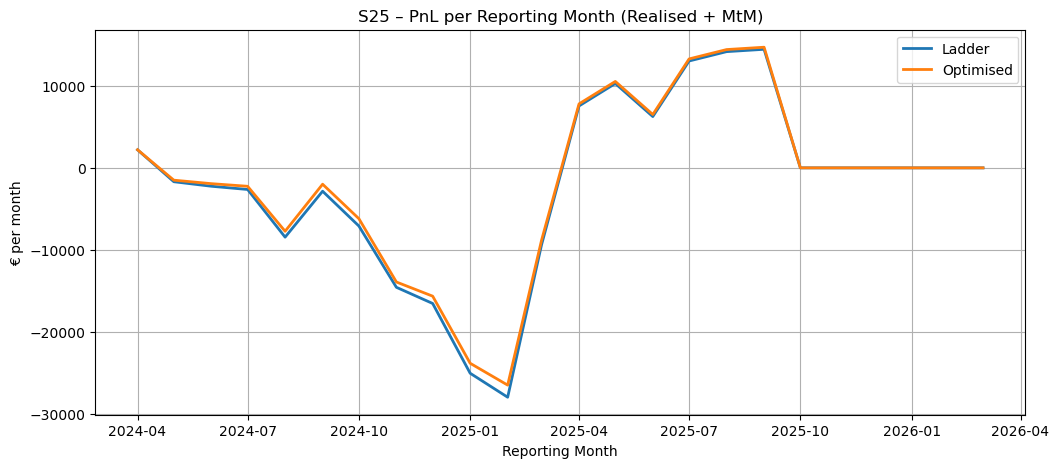

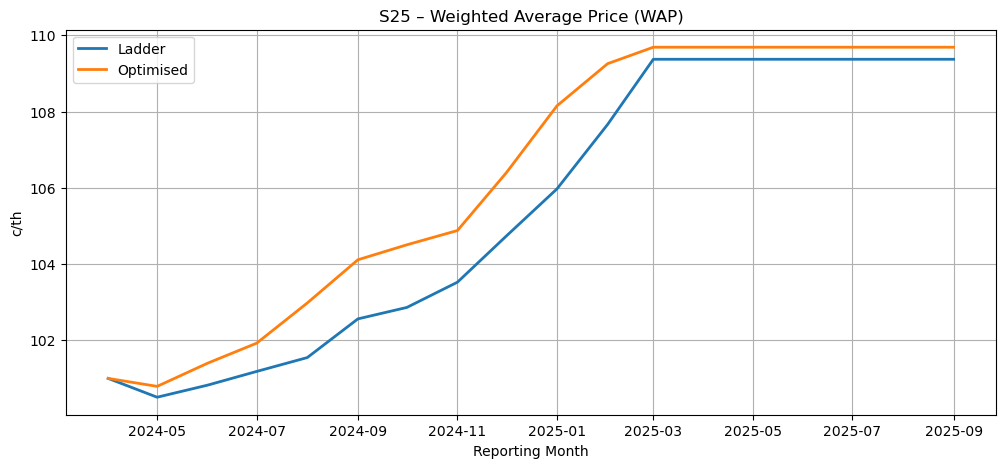

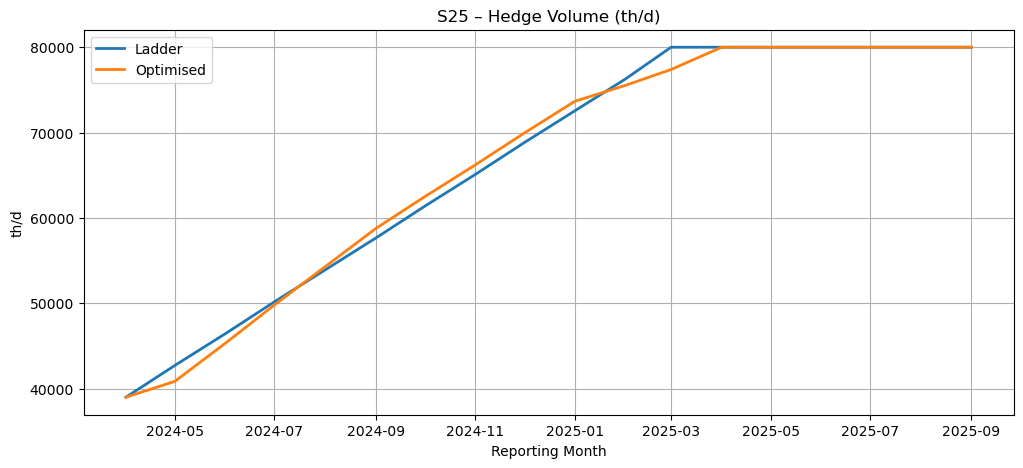


====== W25 ======


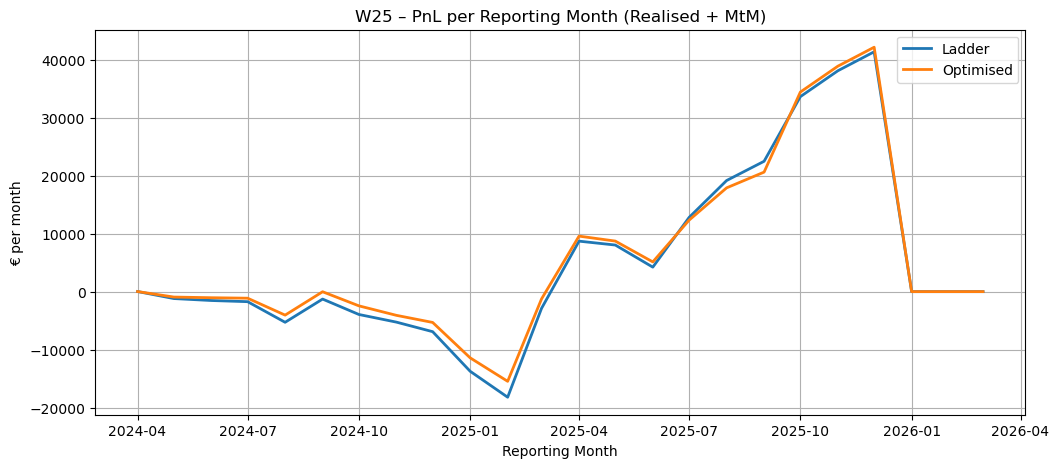

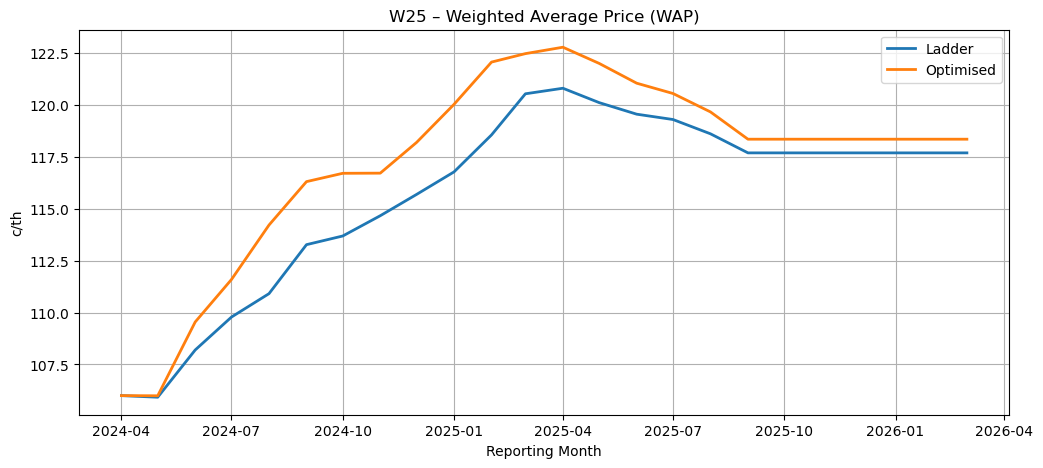

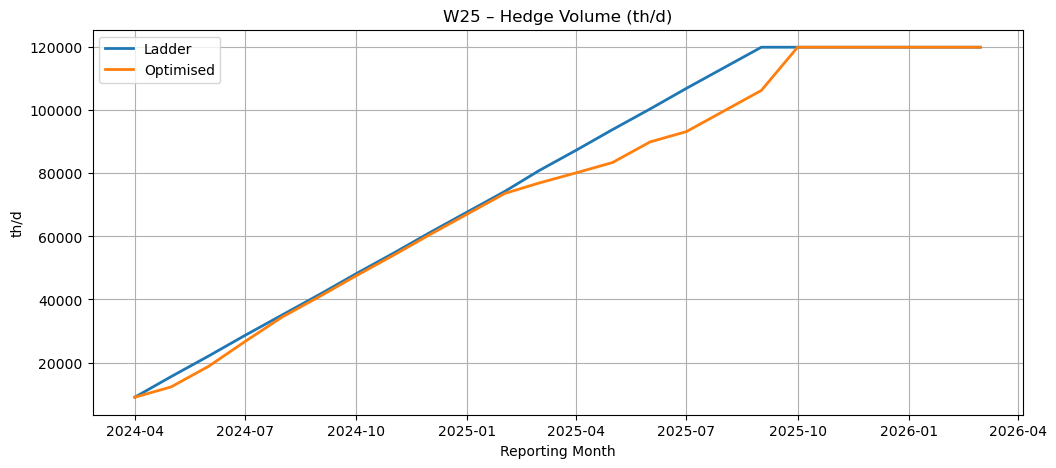

In [10]:
# ============================================
# 9. PLOTTING — 3 plots per season (MtM/Realised, WAP, Volume)
# ============================================

def plot_season(season, df):

    # Extract series cleanly
    mtmL = df[f"{season}_MtM_Ladder"]
    mtmO = df[f"{season}_MtM_Optimised"]

    realL = df[f"{season}_Realised_Ladder"]
    realO = df[f"{season}_Realised_Optimised"]

    # Combined PnL/MtM series (realised where exists)
    pnl_L = realL.fillna(0) + mtmL.fillna(0)
    pnl_O = realO.fillna(0) + mtmO.fillna(0)

    # ---- 1) MTM / REALISED PER MONTH (TRUE TIMESERIES) ----
    plt.figure(figsize=(12,5))
    plt.plot(df["ReportingMonth"], pnl_L, label="Ladder", linewidth=2)
    plt.plot(df["ReportingMonth"], pnl_O, label="Optimised", linewidth=2)
    plt.title(f"{season} – PnL per Reporting Month (Realised + MtM)")
    plt.ylabel("€ per month")
    plt.xlabel("Reporting Month")
    plt.grid(True)
    plt.legend()
    plt.show()

    # ---- 2) WAP ----
    plt.figure(figsize=(12,5))
    plt.plot(df["ReportingMonth"], df[f"{season}_WAP_Ladder"], label="Ladder", linewidth=2)
    plt.plot(df["ReportingMonth"], df[f"{season}_WAP_Optimised"], label="Optimised", linewidth=2)
    plt.title(f"{season} – Weighted Average Price (WAP)")
    plt.ylabel("c/th")
    plt.xlabel("Reporting Month")
    plt.grid(True)
    plt.legend()
    plt.show()

    # ---- 3) Hedge Volume ----
    plt.figure(figsize=(12,5))
    plt.plot(df["ReportingMonth"], df[f"{season}_HedgeVolume_Ladder"], label="Ladder", linewidth=2)
    plt.plot(df["ReportingMonth"], df[f"{season}_HedgeVolume_Optimised"], label="Optimised", linewidth=2)
    plt.title(f"{season} – Hedge Volume (th/d)")
    plt.ylabel("th/d")
    plt.xlabel("Reporting Month")
    plt.grid(True)
    plt.legend()
    plt.show()


# Render all plots
for s in season_dfs:
    print(f"\n====== {s} ======")
    plot_season(s, season_dfs[s])
